<a href="https://colab.research.google.com/github/ptl-harsh/SHL_Task/blob/main/SHL_Hiring_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗣️ Grammar Scoring System for Spoken Audio

#  Imports and Drive Mounting

In [ ]:


import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import zipfile

# Set random seed for reproducibility
np.random.seed(42)

# Mount Google Drive (for Google Colab users)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Data Loading

In [ ]:


# Define directories
TRAIN_AUDIO_DIR = '/content/drive/MyDrive/Datasets/SHL_Task/dataset/audios_train'
TEST_AUDIO_DIR = '/content/drive/MyDrive/Datasets/SHL_Task/dataset/audios_test'

# Load CSV files
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/SHL_Task/dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/SHL_Task/dataset/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Datasets/SHL_Task/dataset/sample_submission.csv')

print("Training samples:", train_df.shape[0])
print("Test samples:", test_df.shape[0])


Training samples: 444
Test samples: 195


# Feature Extraction Function

In [ ]:


def extract_features(file_path, sr=22050, n_mfcc=13):
    """
    Load an audio file and extract mean and std of MFCC features.
    """
    try:
        y, sr = librosa.load(file_path, sr=sr)
        # Compute MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Take mean and standard deviation of MFCC coefficients
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        features = np.concatenate([mfccs_mean, mfccs_std])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        features = np.zeros(n_mfcc * 2)
    return features


#  Extracting Features from Training Audio Files

In [ ]:

X_train = []
y_train = []

print("Extracting features from training audio files...")
for idx, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    file_name = row['filename']
    label = row['label']
    file_path = os.path.join(TRAIN_AUDIO_DIR, file_name)
    features = extract_features(file_path)
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Extracted features shape (train):", X_train.shape)


Extracting features from training audio files...


100%|██████████| 444/444 [03:41<00:00,  2.00it/s]

Extracted features shape (train): (444, 26)


#  Extracting Features from Test Audio Files

In [ ]:

X_test = []
test_files = []

print("Extracting features from test audio files...")
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    file_name = row['filename']
    file_path = os.path.join(TEST_AUDIO_DIR, file_name)
    features = extract_features(file_path)
    X_test.append(features)
    test_files.append(file_name)

X_test = np.array(X_test)
print("Extracted features shape (test):", X_test.shape)


Extracting features from test audio files...


100%|██████████| 195/195 [01:21<00:00,  2.38it/s]

Extracted features shape (test): (195, 26)


#  Evaluation Metric and Model Initialization

In [ ]:


def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

# Create a Pearson correlation scorer
pearson_scorer = make_scorer(pearson_corr, greater_is_better=True)

# Initialize a RandomForestRegressor (feel free to experiment with other models)
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


#  Cross-Validation and Visualizations

Cross-Validation Pearson Correlation scores: [0.50930532 0.58693964 0.70354799 0.59908329 0.59337028]
Mean CV Pearson Correlation: 0.5984493048725888


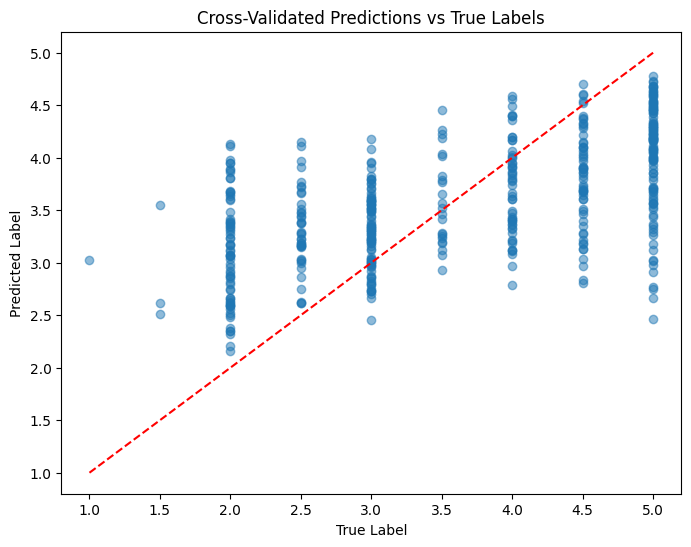

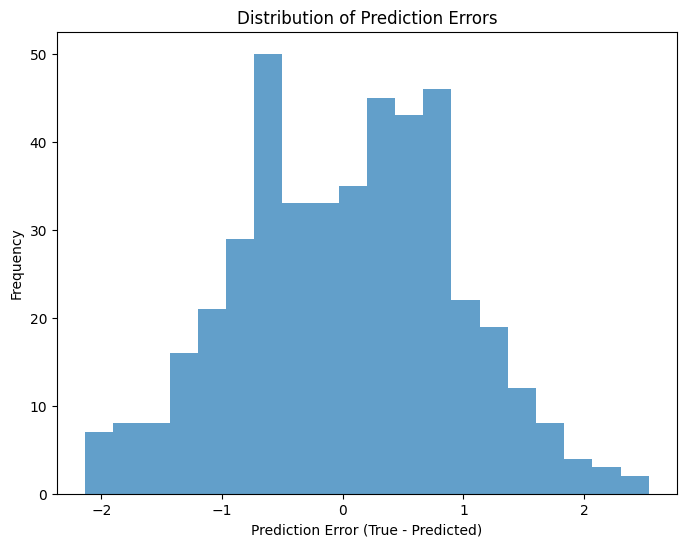

In [ ]:

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=pearson_scorer)
print("Cross-Validation Pearson Correlation scores:", cv_scores)
print("Mean CV Pearson Correlation:", np.mean(cv_scores))

# Obtain cross-validated predictions for the training data
cv_predictions = cross_val_predict(model, X_train, y_train, cv=kf)

# Visualization 1: Scatter Plot of True vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_train, cv_predictions, alpha=0.5)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Cross-Validated Predictions vs True Labels")
# Plot ideal prediction line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
plt.show()

# Visualization 2: Distribution of Prediction Errors
errors = y_train - cv_predictions
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, alpha=0.7)
plt.xlabel("Prediction Error (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


#  Train on Full Data, Feature Importances, and Submission Generation

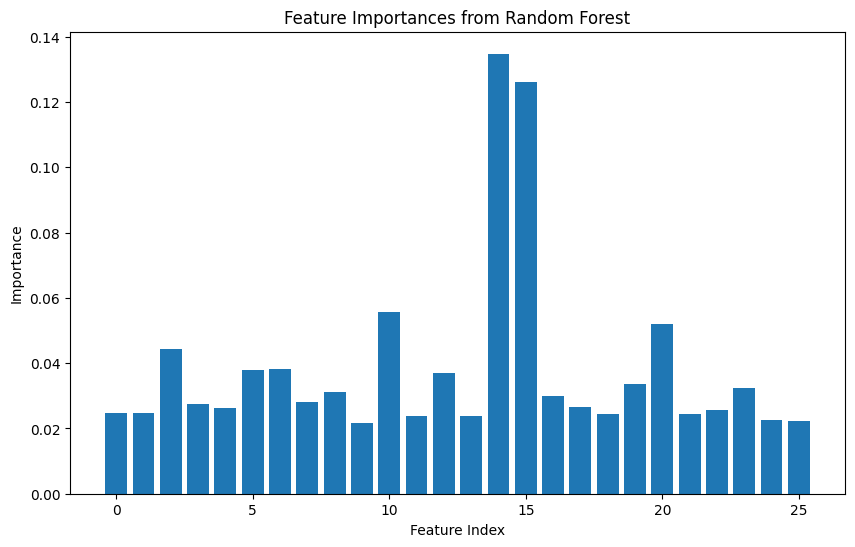

Submission file saved as submission.csv


In [ ]:

# Train the model on the full training data
model.fit(X_train, y_train)

# Visualization 3: Feature Importances (for tree-based models like RandomForest)
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importances from Random Forest")
plt.show()

# Predict on test data
predictions = model.predict(X_test)

# Create submission DataFrame and save as CSV
submission = pd.DataFrame({
    'filename': test_files,
    'label': predictions
})
submission = submission.sort_values('filename')  # Adjust ordering if needed

submission_csv = 'submission.csv'
submission.to_csv(submission_csv, index=False)
print(f"Submission file saved as {submission_csv}")
